In [2]:
%load_ext lab_black

# **CS224W - Colab 1**

In this Colab, we will write a full pipeline for **learning node embeddings**.
We will go through the following 3 steps.

To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

We will then work together to transform the graph structure into a PyTorch tensor, so that we can perform machine learning over the graph.

Finally, we will finish the first learning algorithm on graphs: a node embedding model. For simplicity, our model here is simpler than DeepWalk / node2vec algorithms taught in the lecture. But it's still rewarding and challenging, as we will write it from scratch via PyTorch.

Now let's get started!

**Note**: Make sure to **sequentially run all the cells**, so that the intermediate variables / packages will carry over to the next cell

# 1 Graph Basics
To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

## Setup
We will heavily use NetworkX in this Colab.

In [3]:
import networkx as nx

## Zachary's karate club network

The [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

In [4]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

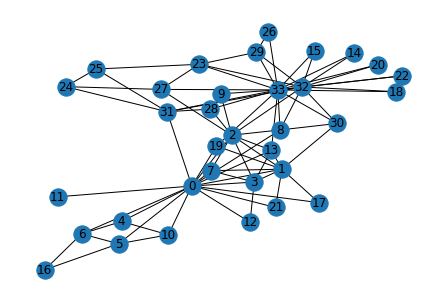

In [5]:
# Visualize the graph
nx.draw(G, with_labels=True)

## Question 1: What is the average degree of the karate club network? (5 Points)

In [9]:
def average_degree(num_edges, num_nodes):
    # degree of a node = num_edges of the node
    # average degree = sum(num_edges of all nodes) / num_nodes
    
    # multiplied by 2 because it's bidirectional (1 edge is owned by 2 nodes)
    return 2 * num_edges / num_nodes


num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 4.588235294117647


## Question 2: What is the average clustering coefficient of the karate club network? (5 Points)

In [10]:
def average_clustering_coefficient(G):
    return nx.average_clustering(G)


avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.5706384782076823


## Question 3: What is the PageRank value for node 0 (node with id 0) after one PageRank iteration? (5 Points)

Please complete the code block by implementing the PageRank equation: $r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$

In [11]:
def one_iter_pagerank(G, beta, r0, node_id):
    r1 = 0
    for neighbor in G.neighbors(node_id):
        r1 += beta * r0 / G.degree[neighbor]
    r1 += (1 - beta) / G.number_of_nodes()
    return r1


beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.12810457516339868




## Question 4: What is the (raw) closeness centrality for the karate club network node 5? (5 Points)

The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [12]:
def closeness_centrality(G, node=5):
    closeness = 0

    closeness = nx.closeness_centrality(G, u=node)
    closeness /= len(nx.node_connected_component(G, node)) - 1

    return closeness


node = 5
closeness = closeness_centrality(G, node=node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 0.011627906976744186


# 2 Graph to Tensor
We will then work together to transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [13]:
import torch

print(torch.__version__)

1.8.0


## PyTorch tensor basics

We can generate PyTorch tensor with all zeros, ones or random values.

In [14]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.7756, 0.5207, 0.7222, 0.1898],
        [0.5815, 0.2169, 0.3171, 0.7558],
        [0.0536, 0.7415, 0.9504, 0.1070]])
torch.Size([3, 4])


PyTorch tensor contains elements for a single data type, the `dtype`.

In [15]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## Question 5: Get the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of `pos_edge_index` tensor? (10 Points)

In [19]:
def graph_to_edge_list(G):
    # just collect edges to a list
    edge_list = []
    for edge in G.edges():
        edge_list.append(edge)

    return edge_list


def edge_list_to_tensor(edge_list):
    # convert list of edges to pytorch tensor
    edge_index = torch.tensor(edge_list).T

    return edge_index


pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("pos_edge_index.shape = {}".format(pos_edge_index.shape))
print("pos_edge_index.sum() = {}".format(torch.sum(pos_edge_index)))

pos_edge_index.shape = torch.Size([2, 78])
pos_edge_index.sum() = 2535


## Question 6: Please implement following function that samples negative edges. Then answer which edges (edge_1 to edge_5) can be potential negative edges in the karate club network? (10 Points)

In [26]:
import random


def sample_negative_edges(G, num_neg_samples):
    # all unconnected edges between lower to higher index of nodes are negative edge
    #   because in this example, the edges don't have weight.
    neg_edge_list = []

    pos_edge_list = graph_to_edge_list(G)
    for node1 in G.nodes():
        for node2 in G.nodes():
            # when from higer to lower node
            if node1 >= node2:
                continue

            # when the edge isn't
            if (node1, node2) in pos_edge_list:
                continue
            neg_edge_list.append((node1, node2))
    neg_edge_list = random.sample(neg_edge_list, num_neg_samples)

    return neg_edge_list

In [27]:
# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

The neg_edge_index tensor has shape torch.Size([2, 78])


In [28]:
# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

pos_edge_list = graph_to_edge_list(G)
for edge in [edge_1, edge_2, edge_3, edge_4, edge_5]:
    edge = (edge[1], edge[0]) if edge[0] > edge[1] else edge
    if edge in pos_edge_list:
        print("No")
    else:
        print("Yes")

No
Yes
No
No
Yes


# 3 Node Emebedding Learning

Finally, we will finish the first learning algorithm on graphs: a node embedding model.


## Setup

In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.8.0


Now, it's your time to create node embedding matrix for the graph we have!
- We want to have **16 dimensional** vector for each node in the karate club network.
- We want to initalize the matrix under **uniform distribution**, in the range of $[0, 1)$. We suggest you using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [74]:
emb = nn.Embedding(num_embeddings=34, embedding_dim=16)

In [40]:
emb.weight.shape

torch.Size([34, 16])

In [44]:
emb.weight[1, :]

tensor([-0.6970, -1.1608,  0.6995,  0.1991,  0.8657,  0.2444, -0.6629,  0.8073,
         1.1017, -0.1759, -2.2456, -1.4465,  0.0612, -0.6177, -0.7981, -0.1316],
       grad_fn=<SliceBackward>)

In [43]:
idx = torch.LongTensor([[1]])
emb(idx)

tensor([[[-0.6970, -1.1608,  0.6995,  0.1991,  0.8657,  0.2444, -0.6629,
           0.8073,  1.1017, -0.1759, -2.2456, -1.4465,  0.0612, -0.6177,
          -0.7981, -0.1316]]], grad_fn=<EmbeddingBackward>)

## Visualize the initial node embeddings
One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then we visualize each point, colored by the community it belongs to.

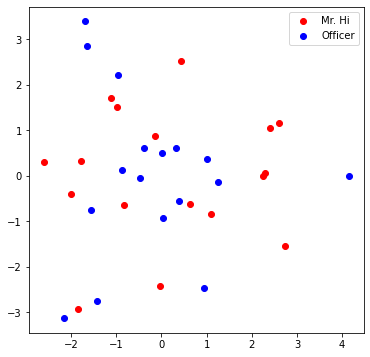

In [45]:
def visualize_emb(emb):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    plt.figure(figsize=(6, 6))
    club1_x = []
    club1_y = []
    club2_x = []
    club2_y = []
    for node in G.nodes(data=True):
        if node[1]["club"] == "Mr. Hi":
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
        else:
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="Officer")
    plt.legend()
    plt.show()


# Visualize the initial random embeddding
visualize_emb(emb)

## Question 7: Training the embedding! What is the best performance you can get? Please report both the best loss and accuracy on Gradescope. (20 Points)

We want to optimize our embeddings for the task of classifying edges as positive or negative. Given an edge and the embeddings for each node, the dot product of the embeddings, followed by a sigmoid, should give us the likelihood of that edge being either positive (output of sigmoid > 0.5) or negative (output of sigmoid < 0.5).

Note that we're using the functions you wrote in the previous questions, _as well as the variables initialized in previous cells_. If you're running into issues, make sure your answers to questions 1-6 are correct.

In [52]:
from torch.optim import SGD
import torch.nn as nn

In [63]:
# Generate the positive and negative labels
print(pos_edge_index.shape, neg_edge_index.shape)
pos_label = torch.ones(pos_edge_index.shape[1])
neg_label = torch.zeros(neg_edge_index.shape[1])

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

torch.Size([2, 78]) torch.Size([2, 78])
torch.Size([2, 156])


In [64]:
train_edge

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  5,  5,  5,  6,  8,  8,  8,  9, 13, 14, 14, 15, 15, 18, 18, 19, 20,
         20, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 28, 28, 29,
         29, 30, 30, 31, 31, 32,  7,  9, 16, 12,  2,  0,  4,  4,  8,  1,  2, 17,
         13, 10, 16,  2,  8,  4,  4, 18, 15,  5, 13, 11, 23, 16,  8, 11, 11,  4,
         24, 20, 22, 12,  7,  5, 13, 14, 29,  5, 11, 12, 15, 14, 21, 10,  0, 19,
          9,  1,  4,  6, 16,  1,  9, 16, 18,  4,  2, 23, 10,  9, 10, 12, 13,  1,
          3, 14, 12, 17,  3,  7, 20,  2, 17,  4, 12, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  2,  3,
          7, 13, 17, 19, 21, 30,  3,  7,  8,  9, 13, 27, 28, 32,  7, 12, 13,  6,
         10,  6, 10, 16, 16, 30, 32, 33, 33, 33, 32, 33, 32, 33, 32, 33, 33, 32,
         33, 32, 33, 25, 27, 29, 32, 33, 25, 27, 31

In [65]:
train_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [73]:
def accuracy(pred, label):
    accu = torch.sum(torch.round(pred) == label) / pred.size(0)
    return accu


def train(emb, loss_fn, sigmoid, train_label, train_edge):
    epochs = 500
    learning_rate = 0.1

    # Binary Cross Entropy loss
    loss_fn = nn.BCELoss()
    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

    for i in range(epochs):
        optimizer.zero_grad()

        # long (2, 156) -> float (2, 156, 16)
        node_emb = emb(train_edge)

        # float (156, 16)x2 -> float (156,) (vector)
        dot_product = torch.sum(node_emb[0] * node_emb[1], -1)

        # make value 0 ~ 1, 0 = negative edge, 1 = positive edge
        result = sigmoid(dot_product)

        loss = loss_fn(result, train_label)
        if (i + 1) % 100 == 0 or i == 0:
            print("Epoch:", i, "Loss:", loss.item(), "Acc:", accuracy(result, train_label).item())
        loss.backward()
        optimizer.step()

In [75]:
train(emb, loss_fn, sigmoid, train_label, train_edge)

Epoch: 0 Loss: 2.083317518234253 Acc: 0.4166666567325592
Epoch: 99 Loss: 0.09802249819040298 Acc: 1.0
Epoch: 199 Loss: 0.03395397216081619 Acc: 1.0
Epoch: 299 Loss: 0.0192561112344265 Acc: 1.0
Epoch: 399 Loss: 0.013147661462426186 Acc: 1.0
Epoch: 499 Loss: 0.009861243888735771 Acc: 1.0


## Visualize the final node embeddings
Visualize your final embedding here! 
You can visually compare the figure with the previous embedding figure. 
After training, you should oberserve that the two classes are more evidently separated. 
This is a great sanitity check for your implementation as well.

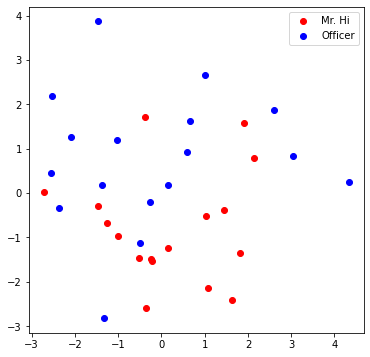

In [76]:
# Visualize the final learned embedding
visualize_emb(emb)

# Submission

In order to get credit, you must go submit your answers on Gradescope.